In [1]:
import h5py
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import re

axisScale = 0.03
datasets = ['organic', 'gm_late', 'gm_early']

datasetNo = 0

# define storage arrays and reshape to hold all three galaxy type data
redshifts = np.array(range(3*24), dtype=float)
redshifts.shape = (3, 24)
kco_s = np.array(range(3*24), dtype=float)
kco_s.shape = (3, 24)
times = np.array(range(3*24), dtype=np.float64)
times.shape = (3, 24)

for dataset in datasets:
    print('-----------------------------------------')
    print(dataset)
    print('-----------------------------------------')
    
    files = listdir('data/' + dataset)

    count = 0
    
    for file in files:
    #if 1==1:



        #file = 'star_particles_015_z002p012.hdf5'
        #file = 'star_particles_028_z000p000.hdf5'
        
        # get redshift from the filename
        m = re.search('(z[0-9])\w+', file)
        s = m.group(0).replace('z', '')
        s = s.replace('p', '.')
        z = float(s)
        
        t0 = 1.38e10
        #if z > 3:
        if z > 0:
            time = (2 * t0) / (3 * np.power(1+z,1.5)) 
       # if z <= 3 and z > 0:
       #     time  = ((z/1+z) * t0)
        if z == 0:
            time = 1.38e10
        
        time = time / 1e9
        
        print ('z=', z)
        print ('t=', format(time,'.1E'))
        
        # load data for a particular galaxy at a particular redshift
        f = h5py.File('data/' + dataset + '/' + file,'r')

        # extract data from the file
        ds_c = f['Coordinates']
        ds_v = f['Velocity']
        ds_m = f['Mass']
    

        # Calculate the resultant angular momentum vectors r
        # r contains the angular momentum vectors for each particle per redshift era
        r0 = np.cross(ds_c, ds_v)
        r = np.transpose(np.multiply(ds_m, np.transpose(r0)))
        #print ("shape r", np.shape(r))
        
        # Calculate the total angular momentum vector by summing the vectors (per redshift epoch)
        angMomTot = np.sum(r, axis=0)
        print ("shape angMomTot", np.shape(angMomTot)) 
        
        # Calculate the magnitude of the total angular momentum vector for each redshift epoch
        # We use this to normalise the angular momentum to a unit vector for scaling during the transform
        magnitude = np.linalg.norm(angMomTot)
        
        # Alternative way of calculating the magnitude
        # magnitude2 = np.sqrt(angMomTot[0]**2 + angMomTot[1]**2 + angMomTot[2]**2)
        
        # Calculate the scale factor by working out the angular momentum 
        unitVect_z = angMomTot / magnitude
        #print ("unitVect_z", unitVect_z)
        #print ("np.linalg.norm(unitVect_z)", np.linalg.norm(unitVect_z))
        
        
        # the angular momentum's vector's (unitVect_z) direction is directly out of the plane of the galaxy
        # unitVect_z = k, but j = [-k2/k1, 1, 0], so
        
        #k = unitVect_z
        #print ("k: ", k)
        
        #j = [k[1]/k[0], 1, 0]
        #print ("j: ", j)
        
        #i = np.cross(j, unitVect_z)
        #print ("i: ", i)
        
        k = unitVect_z
        print ("k: ", k)

        j = [-k[1]/k[0], 1, 0]
        j = j/np.linalg.norm(j)
        print ("j: ", j)

        i = np.cross(j, unitVect_z)
        
        # transform co-ordinates
        dsc_x_trsfrm = np.dot(ds_c, i)
        #print ("dsc_x_trsfrm", dsc_x_trsfrm)
        #print ("dsc_x_trsfrm shape", np.shape(dsc_x_trsfrm))
        
        dsc_y_trsfrm = np.dot(ds_c, j)
        #print ("dsc_y_trsfrm", dsc_y_trsfrm)
        #print ("dsc_y_trsfrm shape", np.shape(dsc_y_trsfrm))
        
        dsc_z_trsfrm = np.dot(ds_c, k)
        #print ("dsc_z_trsfrm", dsc_z_trsfrm)
        #print ("dsc_z_trsfrm shape", np.shape(dsc_z_trsfrm))
        
        #dsc_trans = list(zip(dsc_x_trsfrm, dsc_y_trsfrm, dsc_z_trsfrm))
        dsc_trans = np.transpose(np.array([dsc_x_trsfrm, dsc_y_trsfrm, dsc_z_trsfrm]))
        
        #transform velocities
        dsv_x_trsfrm = np.dot(ds_v, i)
        #print ("dsv_x_trsfrm", dsv_x_trsfrm)
        #print ("dsv_x_trsfrm shape", np.shape(dsv_x_trsfrm))
        
        dsv_y_trsfrm = np.dot(ds_v, j)
        #print ("dsv_y_trsfrm", dsv_y_trsfrm)
        #print ("dsv_y_trsfrm shape", np.shape(dsv_y_trsfrm))
        
        dsv_z_trsfrm = np.dot(ds_v, k)
        #print ("dsv_z_trsfrm", dsv_z_trsfrm)
        #print ("dsv_z_trsfrm shape", np.shape(dsv_z_trsfrm))
        
        dsv_trans = np.transpose(np.array([dsv_x_trsfrm, dsv_y_trsfrm, dsv_z_trsfrm]))
        
        # Get transposed velocity in the x-y plane only
        ##dsv_trans = np.transpose(np.array([dsv_x_trsfrm, dsv_y_trsfrm, dsv_z_trsfrm]))
        
        #print results
        #print ("dsc_trans", dsc_trans)
        #print ("dsc_trans shape", np.shape(dsc_trans))
        
        #print ("dsc_trans[0,x]")
        #print (dsc_trans[0,0])
        #print ("dsc_trans[0,y]")
        #print (dsc_trans[0,1])
        #print ("dsc_trans[0,z]")
        #print (dsc_trans[0,2])        
        
        #print ("dsv_trans", dsv_trans)
        #print ("dsv_trans shape", np.shape(dsv_trans))
        
        #print ("dsv_trans[0,x]")
        #print (dsv_trans[0,0])
        #print ("dsv_trans[0,y]")
        #print (dsv_trans[0,1])
        #print ("dsv_trans[0,z]")
        #print (dsv_trans[0,2])  
       
        # Calculate KE of transformed particles
        # Get magnitudes of the vectors
        vel_magnitude = np.linalg.norm(dsv_trans, axis=1)

        # Calculate kinetic energy for all star particles
        K_tot = np.sum(0.5 * np.array(ds_m) * np.square(vel_magnitude))
        print ('K_tot: ', K_tot)
        ##specificKe = np.sum(0.5 * np.square(vel_magnitude))


        
        # Calculate R, the distance from the centre in the x-y plane
        R = np.sqrt(np.square(dsc_x_trsfrm) + np.square(dsc_y_trsfrm))
        #print ('R shape', np.shape(R))
        #print ('R:', R)
               
        # Calculate momentum 
        res = np.cross(dsc_trans, dsv_trans)
        momentum = np.transpose(np.multiply(ds_m, np.transpose(res)))
        ##momentum = np.multiply(ds_m, res)
        #print('Momentum shape:', np.shape(momentum))
        #print('Momentum',momentum)
        
        # Extract L_z
        L_z = np.array(momentum[:,2])
        #print('L_z:', L_z)    
        
        r0 = 0
        Krot_co = 0
        for n in range(0, len(ds_m)):
            if L_z[n] < 0:
                continue
            if R[n] == 0:
                r0 = r0 + 1
                continue
            Krot_co = Krot_co + (0.5 * ds_m[n] * np.square(L_z[n] / (ds_m[n]*R[n]) ))
        
        print('R=0 count:',r0)
        
        print('Krot_co',Krot_co)
        
        K_co = Krot_co / K_tot
        
        print('K_co',K_co)
        
        redshifts[datasetNo,count] = z
        kco_s[datasetNo,count] = K_co
        times[datasetNo,count] = time
              
        count = count + 1
        print ('-------------------------------------------------')
        
    # Next galaxy
    datasetNo = datasetNo + 1
    
   

-----------------------------------------
organic
-----------------------------------------
z= 7.05
t= 4.0E-01
shape angMomTot (3,)
k:  [0.9515281  0.30598536 0.0311003 ]
j:  [-0.30613344  0.95198861  0.        ]
K_tot:  36702494430.6407
R=0 count: 0
Krot_co 5524279878.332274
K_co 0.15051510705278892
-------------------------------------------------
z= 5.971
t= 5.0E-01
shape angMomTot (3,)
k:  [ 0.65267355 -0.15264495  0.74210293]
j:  [0.22773109 0.97372406 0.        ]
K_tot:  119774170054.30974
R=0 count: 0
Krot_co 37546370059.41599
K_co 0.3134763533939845
-------------------------------------------------
z= 5.487
t= 5.6E-01
shape angMomTot (3,)
k:  [ 0.28733915  0.50012508 -0.81689113]
j:  [-0.86708064  0.49816781  0.        ]
K_tot:  160746946946.82257
R=0 count: 0
Krot_co 42588177690.394905
K_co 0.26493926322895384
-------------------------------------------------
z= 5.037
t= 6.2E-01
shape angMomTot (3,)
k:  [-0.0927266   0.99391521  0.05945022]
j:  [0.99567629 0.0928909  0.       

shape angMomTot (3,)
k:  [ 0.43246331  0.40074935 -0.80769762]
j:  [-0.67970053  0.73348974  0.        ]
K_tot:  18831936036446.086
R=0 count: 1
Krot_co 8072787732864.816
K_co 0.4286754010443364
-------------------------------------------------
z= 0.271
t= 6.4E+00
shape angMomTot (3,)
k:  [ 0.42238713  0.59853831 -0.68069156]
j:  [-0.81703892  0.57658252  0.        ]
K_tot:  20599576889648.26
R=0 count: 1
Krot_co 9638804413452.807
K_co 0.46791273748425954
-------------------------------------------------
z= 0.183
t= 7.2E+00
shape angMomTot (3,)
k:  [ 0.42571865  0.71234153 -0.55797238]
j:  [-0.85838809  0.51300086  0.        ]
K_tot:  20523756605165.45
R=0 count: 1
Krot_co 9890304161701.756
K_co 0.4818954128121238
-------------------------------------------------
z= 0.101
t= 8.0E+00
shape angMomTot (3,)
k:  [ 0.40161615  0.73286378 -0.549195  ]
j:  [-0.87695206  0.48057787  0.        ]
K_tot:  22796719730851.383
R=0 count: 1
Krot_co 10590940415134.715
K_co 0.464581770543142
-----------

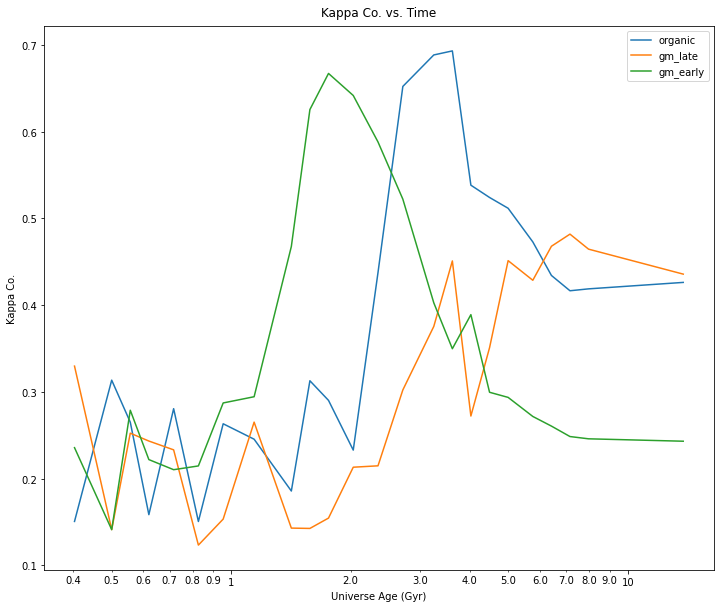

In [2]:
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.1f"

plt.figure(figsize = (12,10))
plt.title('Kappa Co. vs. Time', pad=10)
plt.xlabel('Universe Age (Gyr)')
plt.ylabel('Kappa Co.')
plt.ticklabel_format(axis='x', style='plain', useMathText=False, useOffset=False)
plt.semilogx()

for i in range(0,3):
   plt.plot(times[i,0:], kco_s[i,0:])

plt.legend(['organic', 'gm_late', 'gm_early'])
plt.tick_params(axis='x', which='minor')
ax=plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_minor_formatter(ScalarFormatterClass())


#plt.xlim(0.3, 20)

plt.show()   